<a href="https://colab.research.google.com/github/DanAkarca/modular_experts/blob/main/LPN_modular_experts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This implementation will train a latent programme search network that is itself a mixture of expert design: to be able to find programmes solving a pattern generation task.

Using device: cpu
Epoch [0/100], Loss: 1070.4674
Epoch [10/100], Loss: 317.0847
Epoch [20/100], Loss: 175.5333
Epoch [30/100], Loss: 102.7173
Epoch [40/100], Loss: 65.2828
Epoch [50/100], Loss: 47.2148
Epoch [60/100], Loss: 39.7403
Epoch [70/100], Loss: 34.1365
Epoch [80/100], Loss: 32.5578
Epoch [90/100], Loss: 30.8229


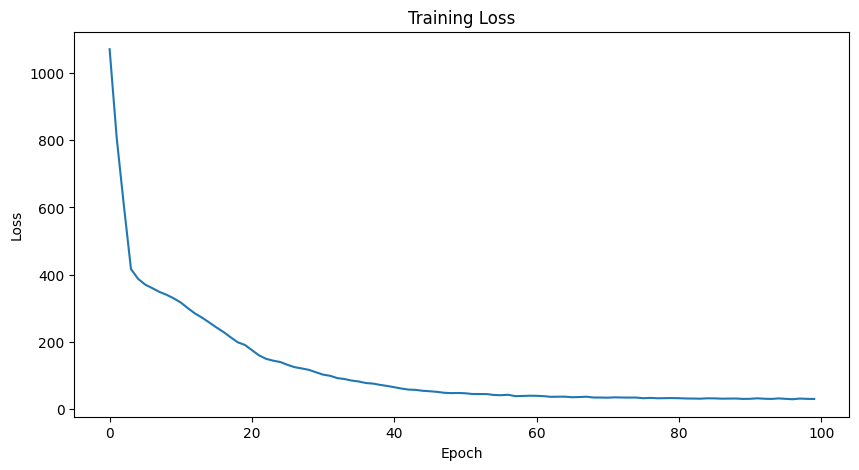

Search step 0, Loss: 0.2538
Search step 20, Loss: 0.0028
Search step 40, Loss: 0.0005
Search step 60, Loss: 0.0002
Search step 80, Loss: 0.0002


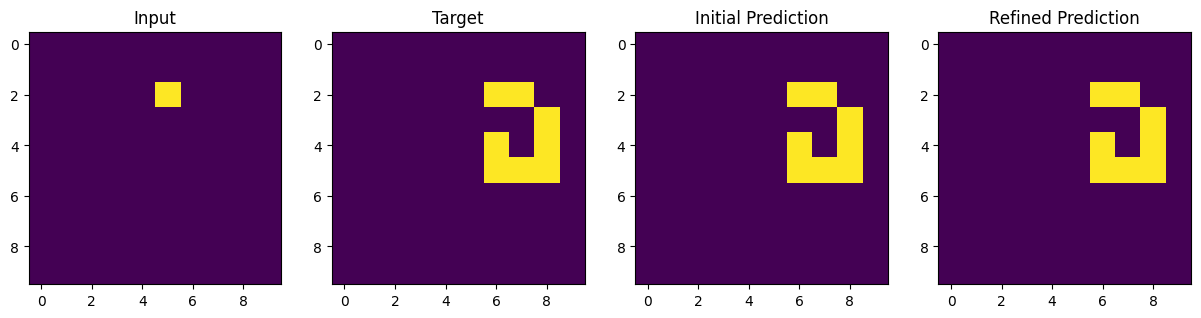

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

class SimpleLPN(nn.Module):
    def __init__(self, input_size=10, latent_dim=32, num_experts=4):
        super().__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_size * input_size * 2, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )

        # Latent projections
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_var = nn.Linear(128, latent_dim)

        # Experts (decoders) - Note the Sigmoid at the end of each expert
        self.experts = nn.ModuleList([
            nn.Sequential(
                nn.Linear(latent_dim + input_size * input_size, 256),
                nn.ReLU(),
                nn.Linear(256, input_size * input_size),
                nn.Sigmoid()  # Ensure output is between 0 and 1
            ) for _ in range(num_experts)
        ])

        # Router
        self.router = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_experts)
        )

        self.input_size = input_size
        self.latent_dim = latent_dim
        self.num_experts = num_experts

    def encode(self, x, y):
        xy = torch.cat([x.flatten(1), y.flatten(1)], dim=1)
        h = self.encoder(xy)
        return self.fc_mu(h), self.fc_var(h)

    def reparameterize(self, mu, log_var):
        if self.training:
            std = torch.exp(0.5 * log_var)
            eps = torch.randn_like(std)
            return mu + eps * std
        return mu

    def decode(self, x, z):
        # Get expert routing weights
        routing_weights = F.softmax(self.router(z), dim=-1)

        # Combine input with latent for each expert
        xz = torch.cat([x.flatten(1), z], dim=1)

        # Get expert outputs
        expert_outputs = []
        for i, expert in enumerate(self.experts):
            out = expert(xz)
            # Scale by routing weight
            out = out * routing_weights[:, i:i+1]
            expert_outputs.append(out)

        # Sum expert outputs and ensure between 0 and 1
        combined = torch.clamp(sum(expert_outputs), 0, 1)
        return combined.view(x.shape)

    def forward(self, x, y=None, z=None):
        if z is not None:
            # Direct decoding mode
            return self.decode(x, z)

        # Training mode
        mu, log_var = self.encode(x, y)
        z = self.reparameterize(mu, log_var)
        recon = self.decode(x, z)
        return recon, mu, log_var

def generate_pattern_data(batch_size=32, grid_size=10, pattern_size=4):
    inputs = torch.zeros(batch_size, grid_size, grid_size)
    outputs = torch.zeros(batch_size, grid_size, grid_size)

    for b in range(batch_size):
        # Random pattern
        pattern = torch.randint(0, 2, (pattern_size, pattern_size), dtype=torch.float32)

        # Random position for marker
        pos_x = torch.randint(0, grid_size-pattern_size+1, (1,))
        pos_y = torch.randint(0, grid_size-pattern_size+1, (1,))

        # Place marker in input
        inputs[b, pos_x, pos_y] = 1.0

        # Place pattern in output
        outputs[b, pos_x:pos_x+pattern_size, pos_y:pos_y+pattern_size] = pattern

    return inputs, outputs

def train_model(model, num_epochs=100, batch_size=32):
    device = next(model.parameters()).device
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    losses = []

    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        num_batches = 100

        for _ in range(num_batches):
            x, y = generate_pattern_data(batch_size=batch_size)
            x, y = x.to(device), y.to(device)

            recon, mu, log_var = model(x, y)

            # Reconstruction loss
            recon_loss = F.binary_cross_entropy(recon, y, reduction='sum')

            # KL divergence
            kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

            # Total loss
            loss = recon_loss + 0.01 * kl_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / num_batches
        losses.append(avg_loss)

        if epoch % 10 == 0:
            print(f'Epoch [{epoch}/{num_epochs}], Loss: {avg_loss:.4f}')

    return losses

def latent_search(model, x, y, num_steps=100, lr=0.1):
    model.eval()
    device = x.device
    z = torch.randn(x.shape[0], model.latent_dim, device=device, requires_grad=True)
    optimizer = torch.optim.Adam([z], lr=lr)

    best_loss = float('inf')
    best_z = None

    for step in range(num_steps):
        optimizer.zero_grad()

        # Decode with current latent
        pred = model(x, z=z)

        # Compute loss
        loss = F.binary_cross_entropy(pred, y)

        if loss.item() < best_loss:
            best_loss = loss.item()
            best_z = z.detach().clone()

        # Update latent
        loss.backward()
        optimizer.step()

        if step % 20 == 0:
            print(f'Search step {step}, Loss: {loss.item():.4f}')

    return best_z

if __name__ == "__main__":
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Create model
    model = SimpleLPN(input_size=10, latent_dim=32, num_experts=4).to(device)

    # Train
    losses = train_model(model, num_epochs=100)

    # Plot training losses
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    # Test
    model.eval()
    with torch.no_grad():
        # Generate test data
        x_test, y_test = generate_pattern_data(batch_size=1)
        x_test, y_test = x_test.to(device), y_test.to(device)

        # Get initial prediction
        initial_pred, _, _ = model(x_test, y_test)

    # Perform latent search
    z_refined = latent_search(model, x_test, y_test)

    with torch.no_grad():
        # Get refined prediction
        refined_pred = model(x_test, z=z_refined)

        # Move to CPU for plotting
        x_test = x_test.cpu()
        y_test = y_test.cpu()
        initial_pred = initial_pred.cpu()
        refined_pred = refined_pred.cpu()

        # Plot results
        fig, axes = plt.subplots(1, 4, figsize=(15, 4))
        axes[0].imshow(x_test[0])
        axes[0].set_title('Input')
        axes[1].imshow(y_test[0])
        axes[1].set_title('Target')
        axes[2].imshow(initial_pred[0])
        axes[2].set_title('Initial Prediction')
        axes[3].imshow(refined_pred[0])
        axes[3].set_title('Refined Prediction')
        plt.show()